In [1]:
%load_ext autoreload

%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from math import exp
from scipy.stats import chi2
from numpy.testing import assert_array_almost_equal

from ruspy.data.data_reading import data_reading
from ruspy.data.data_processing import data_processing

from ruspy.estimation.estimation import estimate
from ruspy.estimation.estimation_cost_parameters import calc_fixp
from ruspy.estimation.estimation_cost_parameters import converge_choice, lin_cost, cost_func, create_transition_matrix
from ruspy.estimation.estimation_cost_parameters import choice_prob
from ruspy.simulation.robust_sim import get_worst_trans



In [2]:
beta = 0.9999
init_dict = {
    'groups': 'group_4',
    'beta': beta,
    'maint_func': 'linear',
    'binsize': 5000,
    'states': 90,
}


In [3]:
data_reading()

In [4]:
repl_data = data_processing(init_dict)

In [5]:
trans_results, cost_results = estimate(init_dict, repl_data)

In [6]:
p_ml = trans_results['x']
np.round(p_ml, 3)

array([0.392, 0.595, 0.013])

In [22]:
num_states = 40
params = [10, 150]
costs = cost_func(num_states, lin_cost, params)
init_dict['params'] = params

In [23]:
trans_mat = create_transition_matrix(num_states, p_ml)
choice_ml = converge_choice(num_states, trans_mat, costs, beta)
p_ml

array([0.39189189, 0.59529357, 0.01281454])

In [24]:
ev = calc_fixp(num_states, trans_mat, costs, beta)
choice_ml_2 = choice_prob(ev, costs, beta)

In [25]:
assert_array_almost_equal(choice_ml, choice_ml_2)

[]

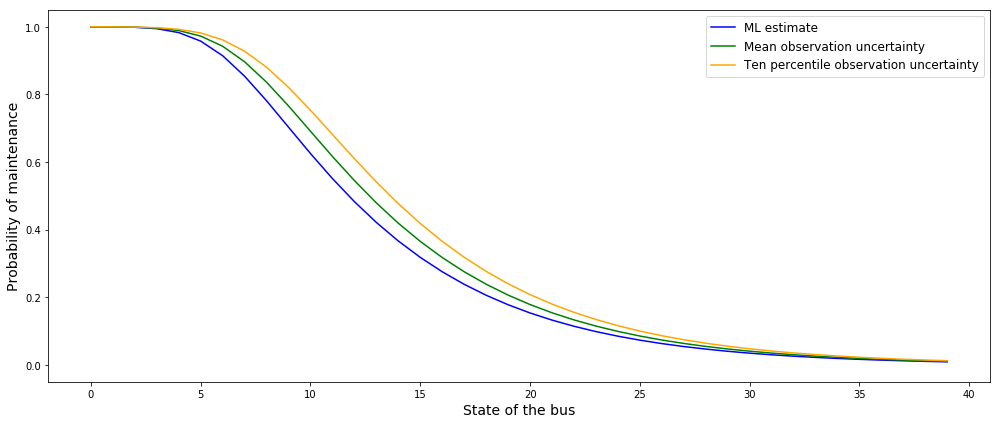

In [38]:
states = range(num_states)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111)
ax.set_ylim([-0.05, 1.05])
ax.set_ylabel(r"Probability of maintenance",fontsize=14)
ax.set_xlabel(r"State of the bus", fontsize=14)
ax.plot(states[:], choice_ml_2[:, 0], color='blue', label='ML estimate')
# ax.plot(states[:], choice_worst_full[:, 0], color='red', label='Full sample uncertainty')
ax.plot(states[:], choice_worst_mean[:, 0], color='green', label='Mean observation uncertainty')
ax.plot(states[:], choice_worst_ten_percent[:, 0], color='orange', label='Ten percentile observation uncertainty')


plt.legend()
ax.legend(fontsize=12)
plt.tight_layout()

plt.plot()

In [27]:
np.max(choice_worst_ten_percent[:, 0] - choice_ml_2[:, 0])

NameError: name 'choice_worst_ten_percent' is not defined

In [28]:
omega = 0.95

In [29]:
roh = chi2.ppf(omega, len(p_ml) - 1) / (2 * 4292)
roh

0.0006979804924403517

In [30]:
worst_trans_full = get_worst_trans(init_dict, p_ml, roh, num_states)
trans_mat = create_transition_matrix(num_states, worst_trans_full)
choice_worst_full = converge_choice(num_states, trans_mat, costs, beta)
worst_trans_full

array([0.37403346, 0.61196328, 0.01400326])

In [31]:
np.round(worst_trans_full, 3)

array([0.374, 0.612, 0.014])

In [32]:
mean_obs = np.mean(np.sum(trans_results['state_count'], axis=1))
roh = chi2.ppf(omega, len(p_ml) - 1) / (2 * mean_obs)
roh

0.05444247841034743

In [33]:
worst_trans_mean = get_worst_trans(init_dict, p_ml, roh, num_states)
trans_mat = create_transition_matrix(num_states, worst_trans_mean)
choice_worst_mean = converge_choice(num_states, trans_mat, costs, beta)
np.round(worst_trans_mean,3)

array([0.242, 0.73 , 0.028])

In [34]:
ten_percent_obs = np.percentile(np.sum(trans_results['state_count'], axis=1), 10)
ten_percent_obs

10.9

In [35]:
roh = chi2.ppf(omega, len(p_ml) - 1) / (2 * ten_percent_obs)
roh

0.27483782326183387

In [36]:
worst_trans_ten_percent = get_worst_trans(init_dict, p_ml, roh, num_states)
trans_mat = create_transition_matrix(num_states, worst_trans_ten_percent)
choice_worst_ten_percent = converge_choice(num_states, trans_mat, costs, beta)
worst_trans_ten_percent

array([0.09681951, 0.82527091, 0.07790958])

## Quentin Andre

First I replicate the plot in cell 133 of [Quentin Andre](https://github.com/QuentinAndre/John-Rust-1987-Python/blob/master/Data%20Generation%20and%20Likelihood%20Fit.ipynb)

In [24]:
num_states = 100
params_que = [20, 250] # Needs to be 500 has scale factor is 0.001 and in quentin its 0.5
costs_que = cost_func(num_states, lin_cost, params_que)
que_trans = np.array([0.36, 0.48, 0.16])
trans_mat_que = create_transition_matrix(num_states, que_trans)

In [25]:
beta = 0
ev_que_0 = calc_fixp(num_states, trans_mat_que, costs_que, beta)
choice_que_0 = choice_prob(ev_que_0, costs_que, beta)

In [26]:
beta = 0.99
ev_que = calc_fixp(num_states, trans_mat_que, costs_que, beta)
choice_que_75 = choice_prob(ev_que_75, costs_que, beta)

[]

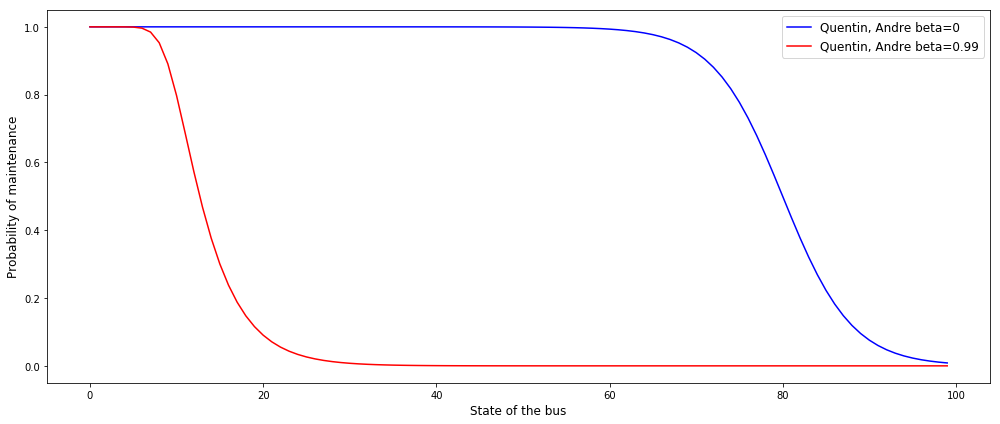

In [27]:
states = range(num_states)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111)
ax.set_ylim([-0.05, 1.05])
ax.set_ylabel(r"Probability of maintenance",fontsize=12)
ax.set_xlabel(r"State of the bus", fontsize=12)
ax.plot(states, choice_que_0[:, 0], color='blue', label='Quentin, Andre beta=0')
ax.plot(states, choice_que_75[:, 0], color='red', label='Quentin, Andre beta=0.99')


plt.legend()
ax.legend(fontsize=12)
plt.tight_layout()

plt.plot()

## Rust

Now I do the same plot with the results of Rust. Its very important to say, that in a simulation the maximal state reached by a bus was just below 150 and I plotted here dwon there up to 500 states. That shows, that the maintainance costs have almost no effect on the decision. This also very intuituve to the fact, that in quentin's model the slope of the linear cost function was 500 * 0.001 = 0.5 and here it is 2.29 * 0.001 = 0.00229. 

In [9]:
# Prepare the raw data.
data_reading()

In [10]:
beta = 0.9999
#Initilize a dictionary with values needed on the way.
init_dict = {
    'groups': 'group_4',
    'beta': beta,
    'maint_func': 'linear',
    'binsize': 5000,
    'states': 90,
}

In [11]:
repl_data = data_processing(init_dict)
trans_results, cost_results = estimate(init_dict, repl_data)
print(trans_results, cost_results)

{'x': array([0.39189189, 0.59529357, 0.01281454]), 'fun': 3140.5705570938244, 'trans_count': [1682, 2555, 55]}       fun: 163.5858399447394
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00031832,  0.00024443])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 45
      nit: 10
   status: 0
  success: True
        x: array([10.07752072,  2.29407949])


In [12]:
params = cost_results['x']
ml_trans = np.array(trans_results['x'])

In [13]:
num_states = 1000
costs = cost_func(num_states, lin_cost, params)
trans_mat_ml = create_transition_matrix(num_states, ml_trans)
ev_ml = calc_fixp(num_states, trans_mat_ml, costs, beta)
choice_ml = choice_prob(ev_ml, costs, beta)

[]

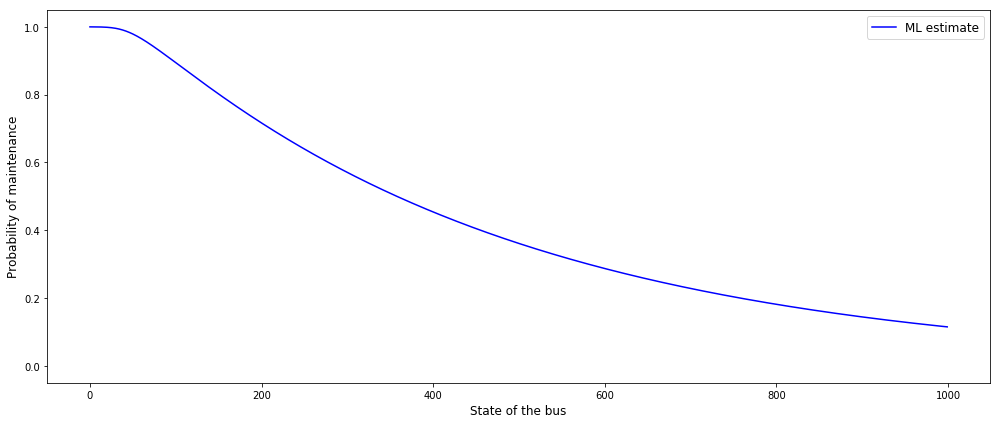

In [14]:
states = range(num_states)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111)
ax.set_ylim([-0.05, 1.05])
ax.set_ylabel(r"Probability of maintenance",fontsize=12)
ax.set_xlabel(r"State of the bus", fontsize=12)
ax.plot(states, choice_ml[:, 0], color='blue', label='ML estimate')


plt.legend()
ax.legend(fontsize=12)
plt.tight_layout()

plt.plot()

In [15]:
max_state = repl_data.state.max()
real_maint = [0] * (max_state + 1)
real_repl = [0] * (max_state + 1)
for i in range(max_state + 1):
    df = repl_data[repl_data.state == i]
    real_repl[i] = df.decision.sum() / df.shape[0]
    real_maint[i] = 1 - real_repl[i]
    

In [17]:
num_states = 90
costs = cost_func(num_states, lin_cost, params)
trans_mat_ml = create_transition_matrix(num_states, ml_trans)
ev_ml = calc_fixp(num_states, trans_mat_ml, costs, beta)
choice_ml = choice_prob(ev_ml, costs, beta)

[]

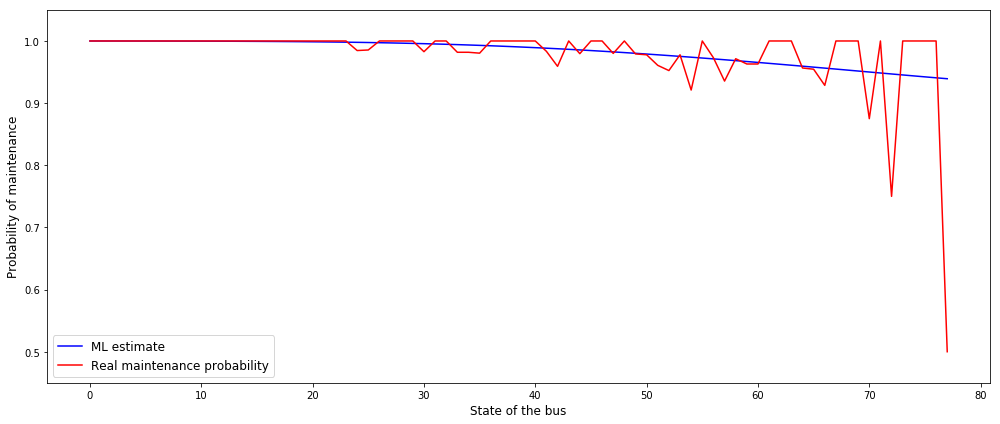

In [18]:
states = range(max_state + 1)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111)
ax.set_ylim([0.45, 1.05])
ax.set_ylabel(r"Probability of maintenance",fontsize=12)
ax.set_xlabel(r"State of the bus", fontsize=12)
ax.plot(states, choice_ml[:max_state + 1, 0], color='blue', label='ML estimate')
ax.plot(states, real_maint, color='red', label='Real maintenance probability')


plt.legend()
ax.legend(fontsize=12)
plt.tight_layout()

plt.plot()

[]

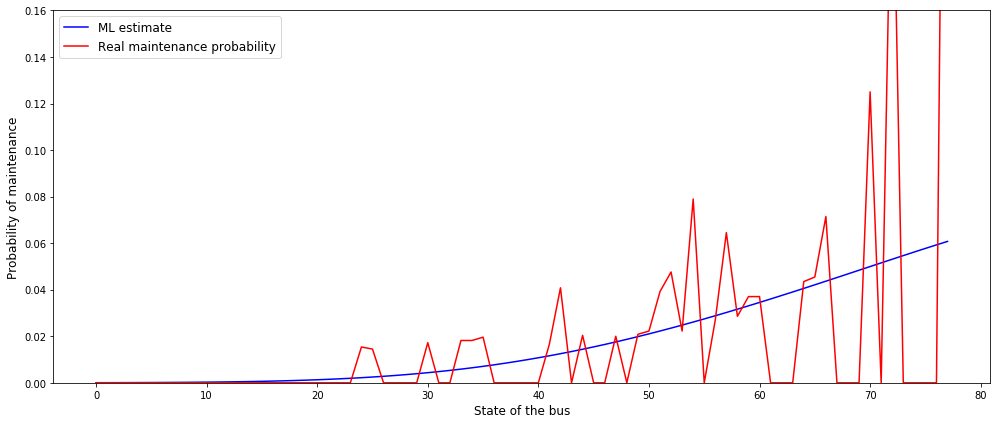

In [19]:
states = range(max_state + 1)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111)
ax.set_ylim([0, 0.16])
ax.set_ylabel(r"Probability of maintenance",fontsize=12)
ax.set_xlabel(r"State of the bus", fontsize=12)
ax.plot(states, choice_ml[:max_state + 1, 1], color='blue', label='ML estimate')
ax.plot(states, real_repl, color='red', label='Real maintenance probability')


plt.legend()
ax.legend(fontsize=12)
plt.tight_layout()

plt.plot()